# Fermion mean field

Mean-field states, including determinants and Pfaffians, are often the starting point in the study of fermionic systems. In this tutorial, we will introduce how to train these states in Quantax.

## Hubbard model

We utilize the 16x4 Hubbard model at 1/8 doping for illustration. As we will see, this system will exhibit stripe pattern, which is also observed in cuprates.

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optimistix as optx
import quantax as qtx
from quantax.operator import number_u, number_d, annihilate_u, annihilate_d

lattice = qtx.sites.Grid(
    (16, 4), particle_type=qtx.PARTICLE_TYPE.spinful_fermion, Nparticles=56
)
N = lattice.Nsites

## Determinant state

The mean-field determinant state is defined as

$$
\ket{\psi_0} = \prod_\alpha \left(\sum_i U_{i\alpha} c_i^\dagger \right) \ket{0},
$$
where $U_{i\alpha}$ denotes trainable mean-field orbitals, and $i$ iterates over both spatial and spinful degrees of freedom.

In [2]:
det_state = qtx.state.GeneralDetState()

The variational energy of mean-field states can be computed exactly, so we can train
these states with exact gradient descent. Here we choose interaction $U=3$, weaker than the usual strongly-correlated regime around $U=8$, because the optimization of mean-field states are unstable under strong interactions.

-67.8069611756783


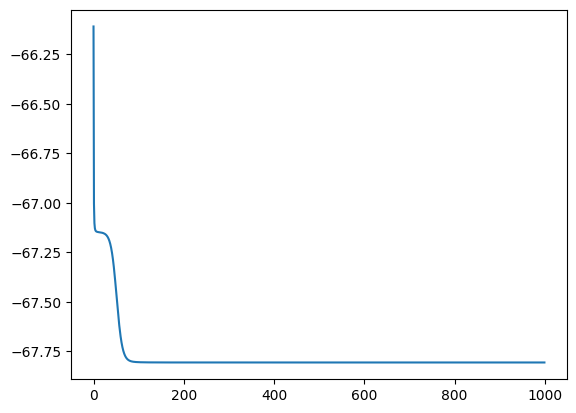

In [3]:
H = qtx.operator.Hubbard(U=3)

energy = qtx.utils.DataTracer()

for i in range(1000):
    step = det_state.get_step(H)
    det_state.update(step * 0.1)
    energy.append(det_state.energy)

print(energy[-1])
energy.plot()
plt.show()

As the energy is computed exactly without stochastic error, one can also optimize it with BFGS to obtain better accuracy as shown below.

In [4]:
params, static = eqx.partition(det_state.model, eqx.is_inexact_array)
loss_fn = det_state.get_loss_fn(H)
solver = optx.BFGS(1e-8, 1e-12)
out = optx.minimise(loss_fn, solver, params, max_steps=10000)
E = loss_fn(out.value)
model = eqx.combine(out.value, static)
det_state = qtx.state.GeneralDetState(model)
print(E)

-67.80696117575036


One can also check how single-particle orbitals look like in the determinant state.

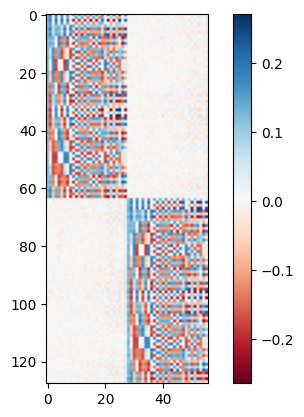

In [5]:
plt.imshow(det_state.model.U_full, "RdBu")
plt.colorbar()
plt.show()

The mean-field states support quick measurement without Monte Carlo noise.
For example, the energy is given by

In [6]:
E0 = det_state.expectation(H)
print(f"Mean-field energy: {E0}")

Mean-field energy: -67.80696117575036


The obtained energy is the final result in the training curve. We can also measure some other quantities, for example, charge and spin densities.

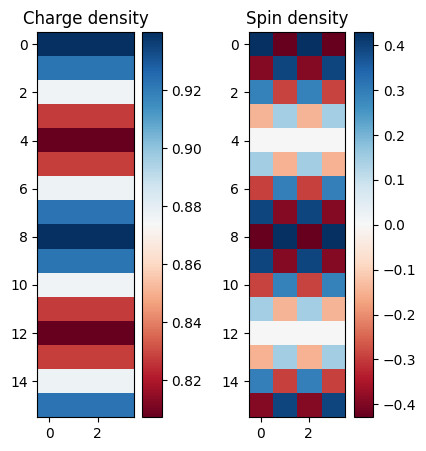

In [7]:
def charge(i):
    return number_u(i) + number_d(i)


def spin(i):
    return number_u(i) - number_d(i)


i = lattice.index_from_xyz[0, 4, 2]
C = [det_state.expectation(charge(i)) for i in range(N)]
C = jnp.asarray(C).reshape(lattice.shape[1:]).real
S = [det_state.expectation(spin(i)) for i in range(N)]
S = jnp.asarray(S).reshape(lattice.shape[1:]).real

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

axes[0].set_title("Charge density")
im = axes[0].imshow(C, cmap="RdBu")
fig.colorbar(im, ax=axes[0])
axes[1].set_title("Spin density")
im = axes[1].imshow(S, cmap="RdBu")
fig.colorbar(im, ax=axes[1])
plt.show()

## BCS state

The BCS state contains pairing between spin-up and spin-down orbitals, i.e.

$$
\ket{\psi_0} = \exp\left( \sum_{ij} F_{ij} c_{i \uparrow}^\dagger c_{j \downarrow}^\dagger \right) \ket{0},
$$

where $F_{ij}$ denotes trainable pairing coefficients, and $i$ and $j$ iterate over spinful degrees of freedom.
As the BCS state doesn't have a fixed amount of particles, the `Nparticles` argument defined in the lattice doesn't apply here.

The pairing appears when there are attractive interactions in the system. For illustration, here we show the result in an attractive Hubbard model. To enforce half-filling, we set $\mu = U/2$.

-50.992768419599656


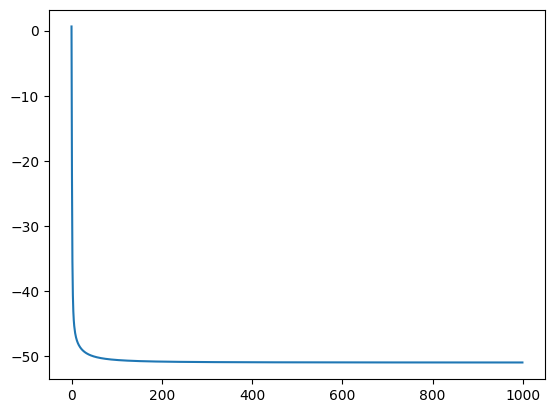

In [8]:
bcs_state = qtx.state.SingletPairState()

H_attractive = qtx.operator.Hubbard(U=-4)
mu = -2
opN = sum(number_u(i) + number_d(i) for i in range(N))
H_attractive -= mu * opN

energy = qtx.utils.DataTracer()

for i in range(1000):
    step = bcs_state.get_step(H_attractive)
    bcs_state.update(step * 0.1)
    energy.append(bcs_state.energy)

print(energy[-1])
energy.plot()
plt.show()

In [9]:
params, static = eqx.partition(bcs_state.model, eqx.is_inexact_array)
loss_fn = bcs_state.get_loss_fn(H_attractive)
solver = optx.BFGS(1e-8, 1e-12)
out = optx.minimise(loss_fn, solver, params, max_steps=10000)
E = loss_fn(out.value)
model = eqx.combine(out.value, static)
bcs_state = qtx.state.SingletPairState(model)

print("Particle number:", bcs_state.expectation(opN))
print("Mean-field energy:", E)

Particle number: 63.99999998101158
Mean-field energy: -50.99616092421495


The matrix $F$ in the definition can be obtained by

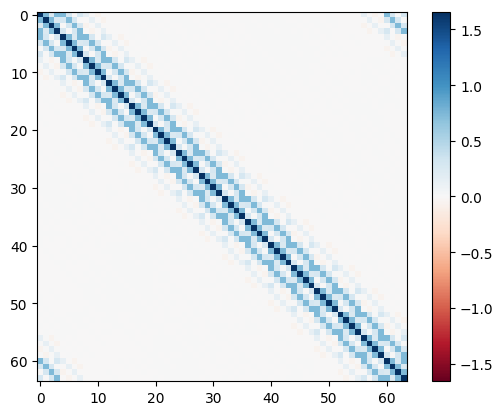

In [13]:
max_val = jnp.max(jnp.abs(bcs_state.model.F_full))
plt.imshow(bcs_state.model.F_full, "RdBu", vmin=-max_val, vmax=max_val)
plt.colorbar()
plt.show()

The observables can be measured similarly.

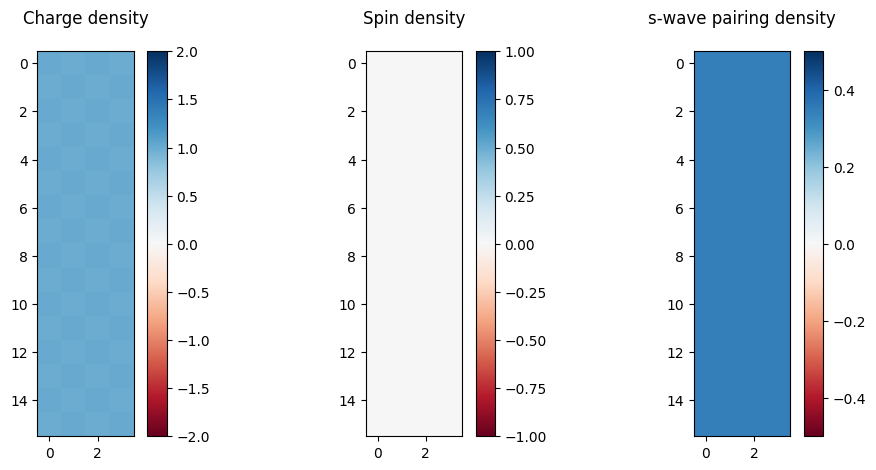

In [12]:
def charge(i):
    return number_u(i) + number_d(i)


def spin(i):
    return number_u(i) - number_d(i)


def Delta_s(i):
    _, x, y = lattice.xyz_from_index[i]
    return (
        annihilate_u(x, y) * annihilate_d(x, y)
        - annihilate_d(x, y) * annihilate_u(x, y)
    ) / 2


C = [bcs_state.expectation(charge(i)) for i in range(N)]
C = jnp.asarray(C).reshape(lattice.shape[1:]).real
S = [bcs_state.expectation(spin(i)) for i in range(N)]
S = jnp.asarray(S).reshape(lattice.shape[1:]).real
Ps = [bcs_state.expectation(Delta_s(i)) for i in range(N)]
Ps = jnp.asarray(Ps).reshape(lattice.shape[1:]).real

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].set_title("Charge density", pad=20)
im = axes[0].imshow(C, cmap="RdBu", vmin=-2, vmax=2)
fig.colorbar(im, ax=axes[0])
axes[1].set_title("Spin density", pad=20)
im = axes[1].imshow(S, cmap="RdBu", vmin=-1, vmax=1)
fig.colorbar(im, ax=axes[1])
axes[2].set_title("s-wave pairing density", pad=20)
im = axes[2].imshow(Ps, cmap="RdBu", vmin=-0.5, vmax=0.5)
fig.colorbar(im, ax=axes[2])
plt.show()

There is nearly homogeneous charge and pairing density in this system.

## Pfaffian state

The Pfaffian state is a generalization of the BCS state to allow general orbitals not restricted by spin species. Its expression is

$$
\ket{\psi_0} = \exp\left( \frac{1}{2} \sum_{ij} F_{ij} c_i^\dagger c_j^\dagger \right) \ket{0},
$$

where $i$ and $j$ iterate over spatial and spinful degrees of freedom. It can be defined and trained as shown below. We don't have orbitals with mixed spins in the solution, so the optimization will give equivalent results compared with the BCS state.

-50.97335331035187


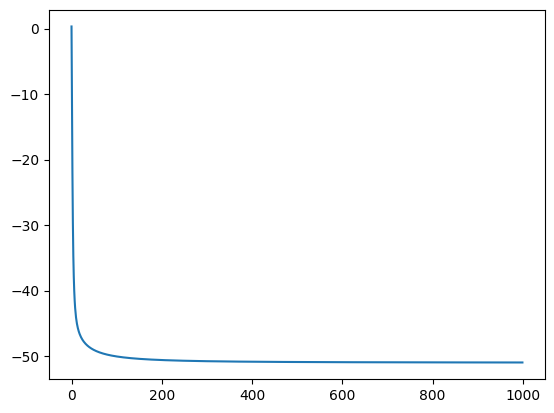

In [14]:
pf_state = qtx.state.GeneralPfState()

energy = qtx.utils.DataTracer()

for i in range(1000):
    step = pf_state.get_step(H_attractive)
    pf_state.update(step * 0.1)
    energy.append(pf_state.energy)

print(energy[-1])
energy.plot()
plt.show()

In [15]:
params, static = eqx.partition(pf_state.model, eqx.is_inexact_array)
loss_fn = pf_state.get_loss_fn(H_attractive)
solver = optx.BFGS(1e-8, 1e-12)
out = optx.minimise(loss_fn, solver, params, max_steps=10000)
E = loss_fn(out.value)
model = eqx.combine(out.value, static)
pf_state = qtx.state.GeneralPfState(model)

print("Particle number:", pf_state.expectation(opN))
print("Mean-field energy:", E)

Particle number: 64.0000000057799
Mean-field energy: -50.996160924215246


The side length of $F$ in the Pfaffian state is double the length in the BCS state to include 2 spin species.

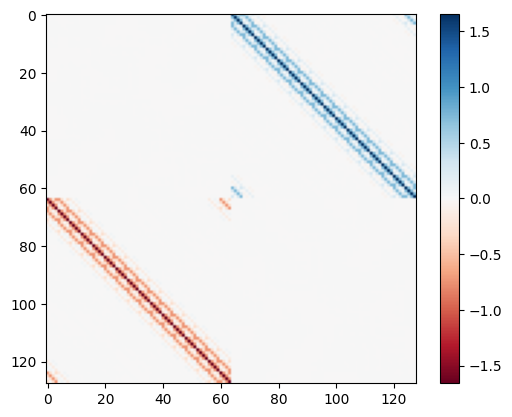

In [17]:
max_val = jnp.max(jnp.abs(pf_state.model.F_full))
plt.imshow(pf_state.model.F_full, "RdBu", vmin=-max_val, vmax=max_val)
plt.colorbar()
plt.show()

The measurement gives similar results.

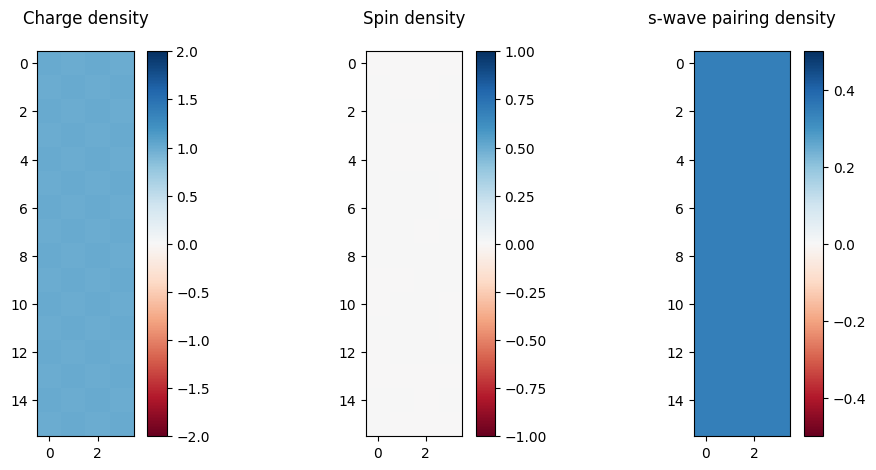

In [19]:
def charge(i):
    return number_u(i) + number_d(i)


def spin(i):
    return number_u(i) - number_d(i)


def Delta_s(i):
    _, x, y = lattice.xyz_from_index[i]
    return (
        annihilate_u(x, y) * annihilate_d(x, y)
        - annihilate_d(x, y) * annihilate_u(x, y)
    ) / 2


C = [pf_state.expectation(charge(i)) for i in range(N)]
C = jnp.asarray(C).reshape(lattice.shape[1:]).real
S = [pf_state.expectation(spin(i)) for i in range(N)]
S = jnp.asarray(S).reshape(lattice.shape[1:]).real
Ps = [pf_state.expectation(Delta_s(i)) for i in range(N)]
Ps = jnp.asarray(Ps).reshape(lattice.shape[1:]).real

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].set_title("Charge density", pad=20)
im = axes[0].imshow(C, cmap="RdBu", vmin=-2, vmax=2)
fig.colorbar(im, ax=axes[0])
axes[1].set_title("Spin density", pad=20)
im = axes[1].imshow(S, cmap="RdBu", vmin=-1, vmax=1)
fig.colorbar(im, ax=axes[1])
axes[2].set_title("s-wave pairing density", pad=20)
im = axes[2].imshow(Ps, cmap="RdBu", vmin=-0.5, vmax=0.5)
fig.colorbar(im, ax=axes[2])
plt.show()